In [1]:
!pip install --upgrade pip
!pip install python-decouple
!pip install geoalchemy2
!pip install shapely
!pip install scipy
!pip3 install xgboost

Requirement already up-to-date: pip in /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages (19.1.1)


In [2]:
from sqlalchemy import create_engine, func, text
from sqlalchemy.orm import sessionmaker
from decouple import config
from shapely import wkb, wkt
from shapely.geometry import Point
from geoalchemy2.shape import to_shape 

import pandas as pd
import numpy as np
import random
import json
from datetime import datetime, timedelta
import re
from matplotlib import pyplot as plt

from sklearn.preprocessing import RobustScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

from IPython.core.debugger import set_trace

Using TensorFlow backend.


In [3]:
"""Contains models for DB."""

from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, BigInteger, Integer, String, DateTime, ForeignKey, Float
from sqlalchemy.orm import relationship
from geoalchemy2 import Geometry


BASE = declarative_base()


class City(BASE):
    """City model for DB. Has information of cities."""
    __tablename__ = 'city'
    id            = Column(BigInteger, primary_key=True)
    city          = Column(String, unique=False, nullable=False)
    state         = Column(String, unique=False, nullable=True)
    country       = Column(String, unique=False, nullable=False)
    location      = Column(Geometry(geometry_type='POINT'), nullable=False)
    blocks        = relationship("Blocks", back_populates="city")
    zipcodes      = relationship("ZipcodeGeom", back_populates="city")
    incidents     = relationship("Incident", back_populates="city")


class Blocks(BASE):
    """Block model for DB. Has information of city blocks for a related city
        id."""
    __tablename__ = 'block'
    id            = Column(BigInteger, primary_key=True)
    cityid        = Column(BigInteger, ForeignKey('city.id'), nullable=False)
    shape         = Column(Geometry(geometry_type='MULTIPOLYGON'), nullable=False)
    population    = Column(Integer, nullable=False)
    city          = relationship("City", back_populates="blocks")
    incidents     = relationship("Incident", back_populates="block")

class ZipcodeGeom(BASE):
    """Zipcode geometry model for DB. Has information of zipcodes and related
        city id."""
    __tablename__ = 'zipcodegeom'
    id            = Column(BigInteger, primary_key=True)
    cityid        = Column(BigInteger, ForeignKey('city.id'), nullable=False)
    zipcode       = Column(String, nullable=False, unique=True)
    shape         = Column(Geometry(geometry_type='MULTIPOLYGON'), nullable=False)
    city          = relationship("City", back_populates="zipcodes")

class Incident(BASE):
    """Incident model for DB. Has information of a specific crime, including
        where it took place, when it took place, and the type of crime that
        occurred."""
    __tablename__ = 'incident'
    id            = Column(BigInteger, primary_key=True)
    crimetypeid   = Column(BigInteger, ForeignKey('crimetype.id'), nullable=False)
    locdescid     = Column(BigInteger, ForeignKey('locdesctype.id'), nullable=False)
    cityid        = Column(BigInteger, ForeignKey('city.id'), nullable=False)
    blockid       = Column(BigInteger, ForeignKey('block.id'), nullable=False)
    location      = Column(Geometry(geometry_type='POINT'), nullable=False)
    datetime      = Column(DateTime, nullable=False)
    hour          = Column(Integer, nullable=False)
    dow           = Column(Integer, nullable=False)
    month         = Column(Integer, nullable=False)
    year          = Column(Integer, nullable=False)
    city          = relationship("City", back_populates="incidents")
    block         = relationship("Blocks", back_populates="incidents")
    crimetype     = relationship("CrimeType", back_populates="incidents")
    locationdesc  = relationship("LocationDescriptionType", back_populates="incidents")

class CrimeType(BASE):
    """CrimeType model for DB. Has information of the types of crime, including
        a general description and the numerical severity of the crime."""
    __tablename__ = 'crimetype'
    id            = Column(BigInteger, primary_key=True)
    category      = Column(String, unique=True, nullable=False)
    severity      = Column(Integer, nullable=False)
    incidents     = relationship("Incident", back_populates="crimetype")


class LocationDescriptionType(BASE):
    """Location description model for DB. Has information on the type of
        location that the crime took place."""
    __tablename__ = 'locdesctype'
    id            = Column(BigInteger, primary_key=True)
    key1          = Column(String, nullable=False)
    key2          = Column(String, nullable=False)
    key3          = Column(String, nullable=False)
    incidents     = relationship("Incident", back_populates="locationdesc")

In [4]:
class GetData(object):
    def go(self, SESSION, start_year, end_year):
        SQL_QUERY = \
            f'''
                WITH
                    max_severity AS (
                        SELECT MAX(severity) AS severity
                        FROM (
                            SELECT SUM(crimetype.severity)/AVG(block.population) AS severity
                            FROM incident
                            INNER JOIN block ON incident.blockid = block.id INNER JOIN crimetype ON incident.crimetypeid = crimetype.id AND block.population > 0
                            GROUP BY
                                incident.blockid,
                                incident.year,
                                incident.month,
                                incident.dow,
                                incident.hour
                        ) AS categories
                    ),
                    block_incidents AS (
                        SELECT
                            incident.blockid,
                            incident.year,
                            incident.month,
                            incident.dow,
                            incident.hour,
                            SUM(crimetype.severity)/AVG(block.population) AS severity
                        FROM incident
                        INNER JOIN block ON incident.blockid = block.id
                        INNER JOIN crimetype ON incident.crimetypeid = crimetype.id
                            AND block.population > 0
                            AND incident.cityid = 1
                            AND incident.year >= {start_year}
                            AND incident.year <= {end_year}
                        GROUP BY
                            incident.blockid,
                            incident.year,
                            incident.month,
                            incident.dow,
                            incident.hour
                    )
                SELECT
                    block_incidents.blockid,
                    block_incidents.year,
                    block_incidents.month,
                    block_incidents.dow,
                    block_incidents.hour,
                    block_incidents.severity/max_severity.severity AS severity
                FROM block_incidents, max_severity        
            '''
        return SESSION.execute(text(SQL_QUERY)).fetchall()

In [5]:
def process_data(data, start_year, end_year, map_risk):

    NUM_BLOCKIDS = 801
    
    X = np.zeros((NUM_BLOCKIDS, 24, 7*24))
    y = np.zeros((NUM_BLOCKIDS, 12, 7*24))
    blockid_dict = {}

    # Create random array (BLOCKIDS) from 1-801 inclusive
    # of length NUM_BLOCKIDS
    BLOCKIDS = random.choices(list(range(1,802)), k=NUM_BLOCKIDS)
    
    for ind, blockid in enumerate(BLOCKIDS):
        blockid_dict[blockid] = ind

    # records is the list of rows we get from the query with this order:
    #   blockid, year, month, dow, hour, risk
    #   month is from 1 - 12

    for r in data:
        if r[0] in blockid_dict:
            if r[1] == end_year:
                # index into array  0-based month
                # vvvvvvvvvvvvvvvv    vvvvvv
                y[blockid_dict[r[0]], r[2]-1, 24*r[3]+r[4]] = map_risk(float(r[5]))
                #                             ^^^^^^^^^^^^^   ^^^^
                #                             hours since     risk
                #                             beginning of
                #                             week
            else:
                # index into array    year 0.....1   month   
                # vvvvvvvvvvvvvvvv    vvvvvvvvvvvvv  vvvvvv
                X[blockid_dict[r[0]], 12*(r[1]-start_year)+r[2]-1, 24*r[3]+r[4]] = map_risk(float(r[5]))
                #                                                  ^^^^^^^^^^^^^   ^^^^
                #                                                  hours since     risk
                #                                                  beginning of
                #                                                  week                
    
    return X, y

In [6]:
from contextlib import contextmanager

@contextmanager
def session_scope():
    """Provide a transactional scope around a series of operations."""

    DB_URI  = config('DB_URI')
    ENGINE  = create_engine(DB_URI)
    Session = sessionmaker(bind=ENGINE)
    SESSION = Session()
    
    try:
        yield SESSION
        SESSION.commit()
    except:
        SESSION.rollback()
        raise
    finally:
        SESSION.close()


def ready_data(training_start_year, training_end_year,
               testing_start_year, testing_end_year,
               map_risk):
    with session_scope() as session:
        training_data = GetData().go(session,
                                     training_start_year,
                                     training_end_year)
        testing_data = GetData().go(session,
                                     testing_start_year,
                                     testing_end_year)
        
        X_train, y_train = process_data(training_data,
                                        training_start_year, 
                                        training_end_year,
                                        map_risk)
        X_test, y_test = process_data(testing_data,
                                      testing_start_year, 
                                      testing_end_year,
                                      map_risk)

    return X_train, X_test, y_train, y_test

In [7]:
def map_risk_1(risk):
    return np.power(risk * 1e5, 2)

def map_risk_0(risk):
    return risk

def map_risk_2(risk):
    return np.power(risk * 1e5, 3)

def map_risk_3(risk):
    return np.power(risk * 1e5, 4)

map_risk = [map_risk_1, map_risk_2, map_risk_3]  # , map_risk_1, map_risk_2, map_risk_3]

In [8]:
%%time
X_train, X_test, y_train, y_test = ready_data(2015, 2016, 2016, 2017, map_risk_0)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


(801, 24, 168) (801, 12, 168) (801, 24, 168) (801, 12, 168)
CPU times: user 1.96 s, sys: 289 ms, total: 2.25 s
Wall time: 44.2 s


In [9]:
def xgb_wrangle(data):
    flat_data = data.flatten()
    X = pd.DataFrame(data={'hour': range(len(flat_data))},
                     index=range(len(flat_data)))
    y = pd.DataFrame(data={'risk': flat_data},
                     index=range(len(flat_data)))
    return X, y

X_train_x, X_train_y = xgb_wrangle(X_train)
X_test_x, X_test_y   = xgb_wrangle(X_test)

## Remove Outliers

### Let's try filtering values that are 20 standard deviations above the mean

In [32]:
FILTER_CRITERIA = 10 # Keep only values 10 std dev below mean

Number of values filtered from y_train: 3229632
Number of values filtered from y_test: 3229632


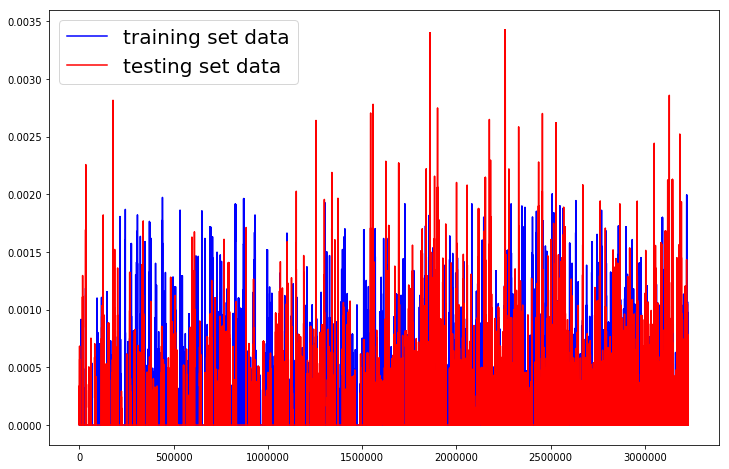

In [33]:
std = np.std(X_train_y)
X_train_y_filtered = X_train_y[X_train_y < FILTER_CRITERIA*std]

std = np.std(X_test_y)
X_test_y_filtered = X_test_y[X_test_y < FILTER_CRITERIA*std]

print('Number of values filtered from y_train:', len(X_train_y[X_train_y > FILTER_CRITERIA*std]))
print('Number of values filtered from y_test:', len(X_test_y[X_test_y > FILTER_CRITERIA*std]))
fig = plt.figure(figsize=(12, 8))
plt.plot(X_train_y_filtered, color='blue');
plt.plot(X_test_y_filtered, color='red');
plt.legend(labels=['training set data', 'testing set data'], prop={'size': 20})
plt.show()

### With our threshold of 20 * std, we have removed 13 points from y_train and 12 from y_test. This is out of 1.6 million points, so they were defintely outliers. Let's run the prediction again with the updated y values

In [34]:
def build_xgb_model(gridsearch=False):
    
    if gridsearch == True:
        param_grid = {
            'learning_rate': [0.01, 0.05, 0.1, 0.5, 0.7],
            'n_estimators':  [80, 100, 120, 200, 500, 900, 2000],
            'max_depth': [2, 3, 4],
        }

        model = GridSearchCV(XGBRegressor(),
                              param_grid=param_grid, 
                              scoring='neg_mean_squared_error', 
                              cv=3, n_jobs=-1,
                              return_train_score=True, verbose=10)
    else:
        model = XGBRegressor()

    return model

In [35]:
std = np.std(train_y)
y_train_updated  = np.where(train_y < FILTER_CRITERIA*std, train_y, [0.]*len(train_y))

std = np.std(test_y)
y_test_updated  = np.where(test_y < FILTER_CRITERIA*std, test_y, [0.]*len(test_y))

In [36]:
model = build_xgb_model()
model.fit(X_train_x, y_train_updated)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [27]:
y_pred = model.predict(X_test_x)
print('MSE:', mean_squared_error(y_test_updated, y_pred))

MSE: 6.081119732767891e-09


In [37]:
def plot_output(y, y_pred, dataset_type):

    fig = plt.figure(figsize=(10, 8))
    plt.plot(np.arange(len(y.flatten())),
                 y.flatten(), color='blue');
    plt.plot(np.arange(len(y_pred.flatten())),
                 y_pred.flatten(), color='red');
    plt.xlabel('Hour since beginning of data', fontsize=16)
    plt.ylabel('Risk', fontsize=18)
    plt.title(dataset_type + ' dataset', fontsize=18)
    plt.legend(labels=['risk', 'predicted risk'], prop={'size': 20})
    plt.show()

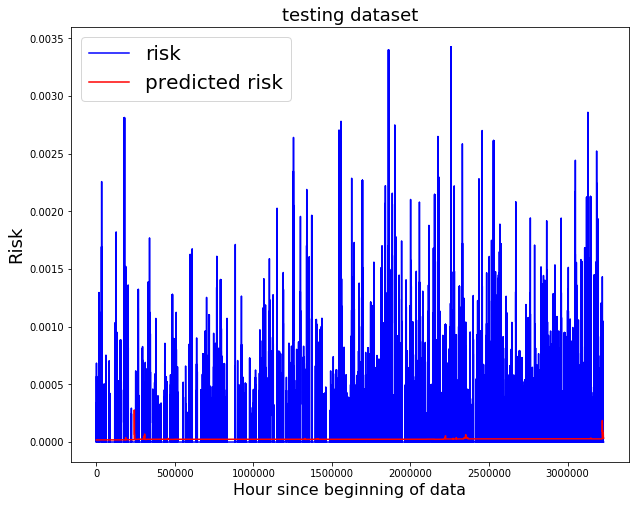

In [38]:
plot_output(y_test_updated, y_pred, 'testing')

In [ ]:
model = build_xgb_model(gridsearch=True)
model.fit(X_train_x, y_train_updated)

Fitting 3 folds for each of 105 candidates, totalling 315 fits
[CV] learning_rate=0.01, max_depth=2, n_estimators=80 ................
[CV] learning_rate=0.01, max_depth=2, n_estimators=80 ................
[CV] learning_rate=0.01, max_depth=2, n_estimators=80 ................
[CV] learning_rate=0.01, max_depth=2, n_estimators=100 ...............
[CV] learning_rate=0.01, max_depth=2, n_estimators=100 ...............
[CV] learning_rate=0.01, max_depth=2, n_estimators=100 ...............
[CV] learning_rate=0.01, max_depth=2, n_estimators=120 ...............
[CV] learning_rate=0.01, max_depth=2, n_estimators=120 ...............
[CV] learning_rate=0.01, max_depth=2, n_estimators=120 ...............
[CV] learning_rate=0.01, max_depth=2, n_estimators=200 ...............
[CV] learning_rate=0.01, max_depth=2, n_estimators=200 ...............
[CV] learning_rate=0.01, max_depth=2, n_estimators=200 ...............
[CV] learning_rate=0.01, max_depth=2, n_estimators=500 ...............
[CV] learning_

In [11]:
print('  Best training score from grid search:', -model.score(X_train_x, y_train_updated))
print('  Best testing score from grid search: ', -model.score(X_test_x, y_test_updated))
if gridsearch == True:
    print('Best Grid Search model:', model.cv_results_['params'][model.best_index_])

  Best training score from grid search: 2.6355339135997872e-08
  Best testing score from grid search:  1.3130647967242946e-07
Best Grid Search model:


In [12]:
y_pred = model.predict(X_test_x)
print('MSE:', mean_squared_error(y_test_updated, y_pred))

MSE: 1.3130647967242946e-07


In [ ]:
plot_output(y_test_updated, y_pred, 'testing')